In [4]:
from pathlib import Path
import joblib
import numpy as np

from cogpred.utils.naming import make_run_path
from cogpred.utils.configuration import get_config
from cogpred.loading import make_test_data

config = get_config()
dir = Path(config["output_dir"]) / "prediction"
ATLAS = "schaefer200"
k = 3

conn_dir = config["connectivity_matrices"]

fc_exps = [
    "k-3_feat-fc_atlas-schaefer200_groupkfold-True_net-Default_inter-Default"
]
volumetry = [
    "k-3_feat-volumetry_atlas-schaefer200_experimental-False"
]

series_exp = [
    "k-3_feat-series_experimental-True_atlas-schaefer200_winsize-48_batchsize-512_niter-50_stamp-2024-07-12-09:44"
]

matrices, metadata = make_test_data(conn_dir, ATLAS, k)
y_test = metadata.cluster_label.values

Dropping 4 subjects because of lacking MMMSE


In [6]:
import json
from sklearn.metrics import f1_score
from sklearn.dummy import DummyClassifier
from cogpred.features import make_features
from cogpred.loading import TSFetcher
from cogpred.models import WindowNetClassifier, BOLDCNN
from torch import nn
from neuroginius.atlas import Atlas
from cogpred.models import default_channel_func, initial_bump, slow_increase, fast_increase, constant_channels

TSPATH = Path("/georges/memento/BIDS/derivatives/schaeffer200_merged_phenotypes")

def evaluate_series_model(expname):
    
    # Fetch features
    atlas = Atlas.from_name(ATLAS)
    fetcher = TSFetcher(TSPATH)
    
    net_indexer = np.where(np.array(atlas.macro_labels) == "SomMot", True, False)
    net_indexer += np.where(np.array(atlas.macro_labels) == "Limbic", True, False)
    exppath = dir / expname
    features = make_features(fetcher, metadata, net_indexer)

    # Rebuild model
    with open(exppath / "architecture.json", "r") as file:
        params = json.load(file)

    params["module__channel_func"] = eval(params["module__channel_func"])

    expdict = dict()
    for k in exppath.name.split("_"):
        exptag = k.split("-")
        expdict[exptag[0]] = exptag[1]
    new_net = WindowNetClassifier(
        module=BOLDCNN,
        module__n_channels=sum(net_indexer),
        module__window_size=int(expdict["winsize"]),
        criterion=nn.CrossEntropyLoss(),
        **params
    )
    new_net.initialize()  # This is important!
    new_net.load_params(f_params=exppath / "params.pkl")

    y_pred = []
    for ts in features:
        ts = ts.T
        ts = ts.reshape(1, *ts.shape)
        p, _ = new_net.sliding_inference(ts, stride=6)
        integral = p.sum(axis=1)
        decision = np.argmax(integral)
        y_pred.append(decision)

    return f1_score(y_test, y_pred, average="macro")
    

def evaluate_fc_model(expname):
    estimator = joblib.load(dir / expname / "best_estimator.joblib")
    y_pred = estimator.predict(matrices)
    return f1_score(y_test, y_pred, average="macro")

def evaluate_dummy_model():
    X_mock = np.ones(len(y_test))
    dum_pred = DummyClassifier().fit(X_mock, y_test).predict(X_mock)
    dum_score = f1_score(y_test, dum_pred, average="macro")
    return dum_score
    

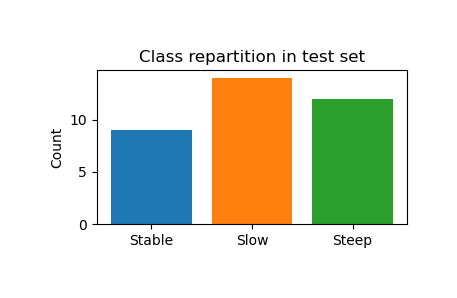

In [7]:
from matplotlib import pyplot as plt
import seaborn as sns
_, counts = np.unique(y_test, return_counts=True)
plt.subplots(figsize=(4, 2))
plt.bar(
    ["Stable", "Slow", "Steep"],
    counts,
    color=sns.color_palette()[:3],
)
plt.ylabel("Count")
plt.title("Class repartition in test set")
plt.show()

In [8]:
import numpy as np

scores = {
    "dummy": evaluate_dummy_model()
}

for fc_exp in fc_exps:
    scores[fc_exp] = evaluate_fc_model(fc_exp)

for ts_exp in series_exp:
    scores[ts_exp] = evaluate_series_model(ts_exp)

scores

47 48
94 24
188 12


{'dummy': 0.19047619047619047,
 'k-3_feat-fc_atlas-schaefer200_groupkfold-True_net-Default_inter-Default': 0.2556750298685782,
 'k-3_feat-series_experimental-True_atlas-schaefer200_winsize-48_batchsize-512_niter-50_stamp-2024-07-12-09:44': 0.34920634920634924}